In [ ]:
import pandas as pd
import numpy as np
from pandas import json_normalize
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from google.colab import files


In [ ]:

# Upload JSON file
uploaded = files.upload()

# Load the JSON file
for filename in uploaded.keys():
    with open(filename, 'r') as f:
        data = json.load(f)

# Normalize JSON (flatten nested structures like actionData, _id, createdAt)
df = json_normalize(
    data,
    sep='_',  # Use underscore for nested keys
)

# Convert timestamp columns to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df['createdAt_$date'] = pd.to_datetime(df['createdAt_$date'])
df['updatedAt_$date'] = pd.to_datetime(df['updatedAt_$date'])

# Preview the DataFrame
df.head()

,userWallet,network,protocol,txHash,logId,timestamp,blockNumber,action,__v,_id_$oid,...,actionData_repayerId,actionData_liquidatorId,actionData_collateralAmount,actionData_collateralAssetPriceUSD,actionData_principalAmount,actionData_borrowAssetPriceUSD,actionData_collateralReserveId,actionData_collateralReserveSymbol,actionData_principalReserveId,actionData_principalReserveSymbol
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,2021-08-17 05:29:26,1629178166,deposit,0,681d38fed63812d4655f571a,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,2021-05-20 15:36:53,1621525013,deposit,0,681aa70dd6df53021cc6f3c0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,2021-07-24 09:28:33,1627118913,deposit,0,681d04c2d63812d4654c733e,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,2021-07-31 23:15:18,1627773318,deposit,0,681d133bd63812d46551b6ef,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,2021-04-19 15:25:07,1618845907,redeemunderlying,0,681899e4ba49fc91cf2f4454,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Convert amount to float (divide by token decimals later)
df['amount'] = df['actionData_amount'].astype(float)
df['price'] = df['actionData_assetPriceUSD'].astype(float)
df['amount_usd'] = df['amount'] * df['price']

In [ ]:
features = []
wallets = df['userWallet'].unique()

for wallet in wallets:
    sub = df[df['userWallet'] == wallet]
    actions = sub['action']

    total_deposit = sub[sub['action'] == 'deposit']['amount_usd'].sum()
    total_borrow = sub[sub['action'] == 'borrow']['amount_usd'].sum()
    total_repay = sub[sub['action'] == 'repay']['amount_usd'].sum()
    total_redeem = sub[sub['action'] == 'redeemunderlying']['amount_usd'].sum()
    total_liquidations = sub[sub['action'] == 'liquidationcall'].shape[0]

    active_days = sub['timestamp'].dt.date.nunique()
    num_tokens = sub['actionData_assetSymbol'].nunique()

    times = sub['timestamp'].sort_values()
    time_gaps = times.diff().dt.total_seconds().dropna() / (60 * 60 * 24)
    avg_gap = time_gaps.mean() if not time_gaps.empty else 0

    repay_ratio = total_repay / total_borrow if total_borrow > 0 else 0
    redeem_ratio = total_redeem / total_deposit if total_deposit > 0 else 0

    features.append({
        'wallet': wallet,
        'total_deposit_usd': total_deposit,
        'total_borrow_usd': total_borrow,
        'total_repay_usd': total_repay,
        'total_redeem_usd': total_redeem,
        'total_liquidations': total_liquidations,
        'repay_to_borrow_ratio': repay_ratio,
        'redeem_to_deposit_ratio': redeem_ratio,
        'active_days': active_days,
        'num_tokens': num_tokens,
        'avg_transaction_gap_days': avg_gap
    })

wallet_df = pd.DataFrame(features)

In [ ]:
wallet_df.head()

,wallet,total_deposit_usd,total_borrow_usd,total_repay_usd,total_redeem_usd,total_liquidations,repay_to_borrow_ratio,redeem_to_deposit_ratio,active_days,num_tokens,avg_transaction_gap_days
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1.987664e+09,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000e+00,0.000000,1,1,0.000000
1,0x000000000051d07a4fb3bd10121a343d85818da6,2.856945e+20,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000e+00,0.000000,1,1,0.000000
2,0x000000000096026fb41fc39f9875d164bd82e2dc,5.152311e+15,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000e+00,0.000000,2,1,7.574132
3,0x0000000000e189dd664b9ab08a33c4839953852c,0.000000e+00,0.000000e+00,0.000000e+00,9.803600e+20,0,0.000000e+00,0.000000,8,4,8.082985
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,2.065773e+23,6.029762e+22,7.015026e+10,1.128745e+23,0,1.163400e-12,0.546403,104,6,0.333834


In [ ]:
scaler = MinMaxScaler()
normalized = scaler.fit_transform(wallet_df[['repay_to_borrow_ratio',
                                              'redeem_to_deposit_ratio',
                                              'active_days',
                                              'num_tokens',
                                              'total_deposit_usd',
                                              'avg_transaction_gap_days']])

wallet_df[['norm_repay', 'norm_redeem', 'norm_days', 'norm_tokens', 'norm_deposit', 'norm_gap']] = normalized


In [ ]:
wallet_df.head()

,wallet,total_deposit_usd,total_borrow_usd,total_repay_usd,total_redeem_usd,total_liquidations,repay_to_borrow_ratio,redeem_to_deposit_ratio,active_days,num_tokens,avg_transaction_gap_days,norm_repay,norm_redeem,norm_days,norm_tokens,norm_deposit,norm_gap
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1.987664e+09,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000e+00,0.000000,1,1,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000,3.281976e-17,0.000000
1,0x000000000051d07a4fb3bd10121a343d85818da6,2.856945e+20,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000e+00,0.000000,1,1,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000,4.717309e-06,0.000000
2,0x000000000096026fb41fc39f9875d164bd82e2dc,5.152311e+15,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000e+00,0.000000,2,1,7.574132,0.000000e+00,0.000000e+00,0.009009,0.000,8.507354e-11,0.079039
3,0x0000000000e189dd664b9ab08a33c4839953852c,0.000000e+00,0.000000e+00,0.000000e+00,9.803600e+20,0,0.000000e+00,0.000000,8,4,8.082985,0.000000e+00,0.000000e+00,0.063063,0.375,0.000000e+00,0.084349
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,2.065773e+23,6.029762e+22,7.015026e+10,1.128745e+23,0,1.163400e-12,0.546403,104,6,0.333834,3.411732e-13,1.159546e-17,0.927928,0.625,3.410948e-03,0.003484


In [ ]:
def improved_score(row):
    score = 0
    score += 200 * row['norm_repay']
    score += 200 * row['norm_redeem']
    score += 100 * row['norm_days']
    score += 100 * row['norm_tokens']
    score += 150 * np.log1p(row['total_deposit_usd']) / np.log1p(wallet_df['total_deposit_usd'].max())
    score -= 200 * row['total_liquidations']
    score = max(min(score, 1000), 0)
    return round(score, 2)

wallet_df['credit_score'] = wallet_df.apply(improved_score, axis=1)


In [ ]:
wallet_df['credit_score'].head()

,credit_score
0,54.10
1,119.01
2,92.31
3,43.81
4,290.94


In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(normalized)
wdf = wallet_df.copy()
wdf['cluster'] = kmeans_labels

# Assign cluster-based score as backup
cluster_mean_scores = wdf.groupby('cluster')['credit_score'].mean().sort_values()
cluster_ranks = {k: i for i, k in enumerate(cluster_mean_scores.index)}
wdf['cluster_score'] = wdf['cluster'].map(lambda x: 200 + 150 * cluster_ranks[x])

In [ ]:
iso = IsolationForest(contamination=0.01, random_state=42)
wdf['anomaly'] = iso.fit_predict(normalized)

# Penalize anomalies if needed
wdf['credit_score'] = np.where(wdf['anomaly'] == -1, wdf['credit_score'] * 0.5, wdf['credit_score'])

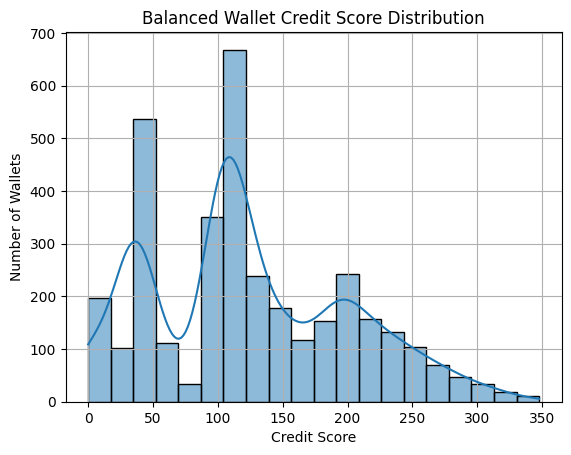

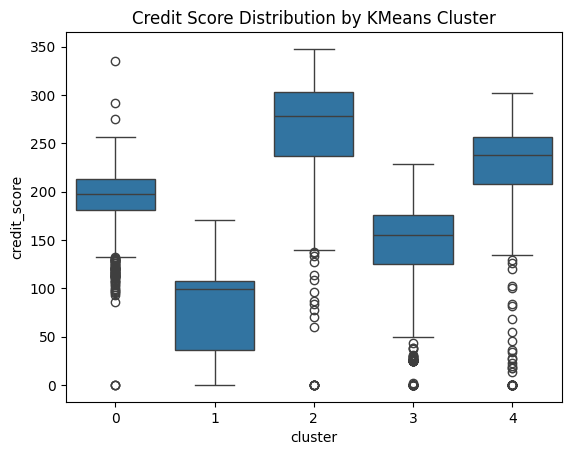

In [ ]:
sns.histplot(wdf['credit_score'], bins=20, kde=True)
plt.xlabel('Credit Score')
plt.ylabel('Number of Wallets')
plt.title('Balanced Wallet Credit Score Distribution')
plt.grid(True)
plt.show()

sns.boxplot(x='cluster', y='credit_score', data=wdf)
plt.title("Credit Score Distribution by KMeans Cluster")
plt.show()


In [ ]:

wdf[['wallet', 'credit_score', 'cluster', 'anomaly']].to_csv("wallet_scores.csv", index=False)
files.download("wallet_scores.csv")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>